В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch.








In [3]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

In [4]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

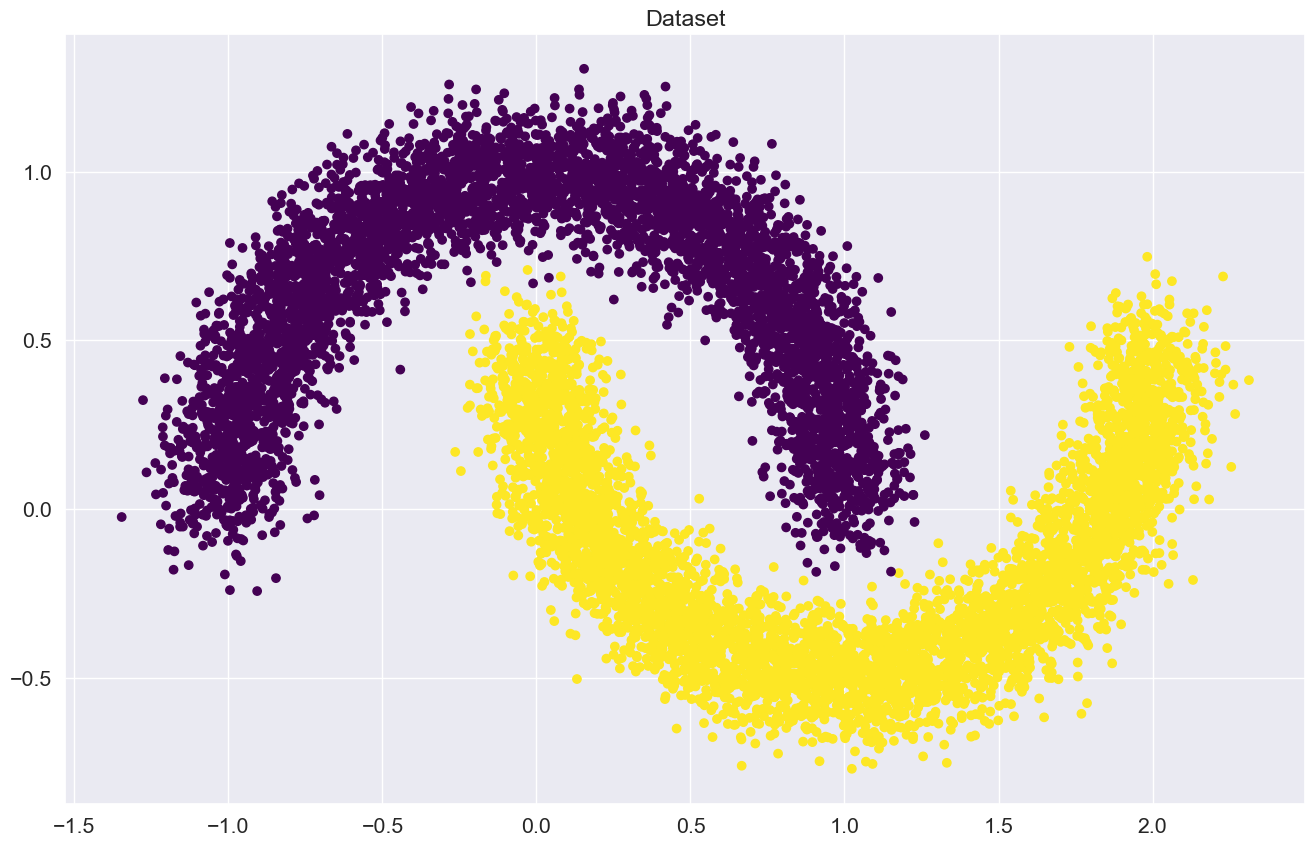

In [5]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [8]:
X_train_t =  torch.from_numpy(X_train).to(torch.float32)
y_train_t =  torch.from_numpy(y_train).to(torch.float32)
X_val_t =  torch.from_numpy(X_val).to(torch.float32)
y_val_t =  torch.from_numpy(y_val).to(torch.float32)

Создаем `Dataset` и `DataLoader`.

In [9]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression

**Напоминание**
На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [10]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [11]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

Для класса LinearRegression: (in_features + 1) * out_features 

Для instance LinearRegression(2, 1): 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [13]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch).squeeze(1)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.2578125
Iteration: 100
Batch accuracy: 0.78125
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.8828125
Iteration: 400
Batch accuracy: 0.8515625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125
Iteration: 800
Batch accuracy: 0.84375

Iteration: 814.Convergence. Stopping iterations.


### Визуализируем результаты

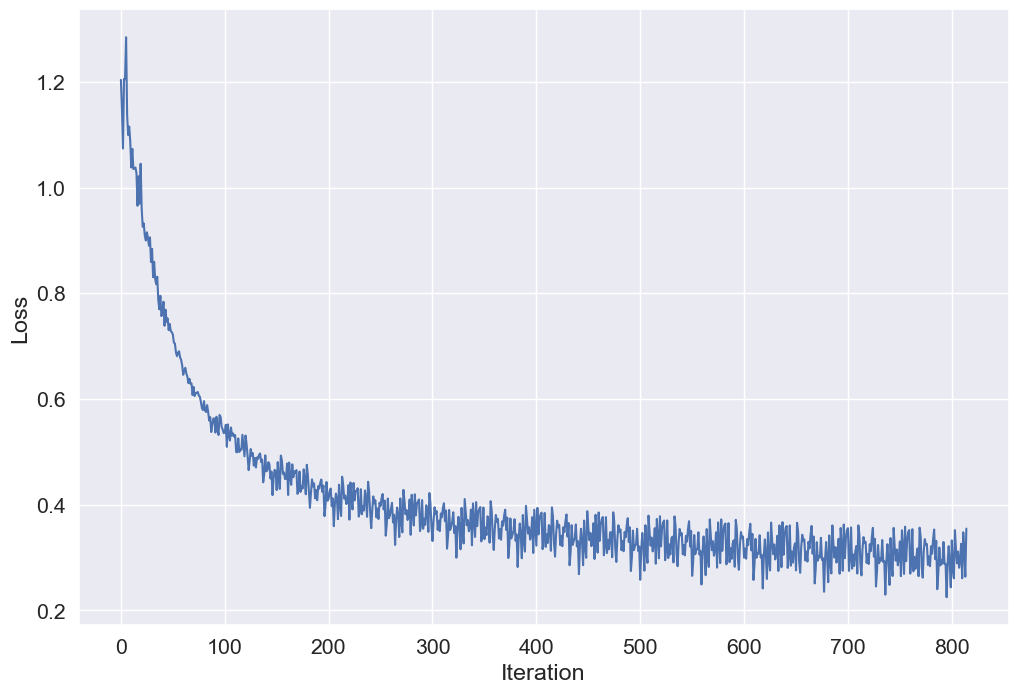

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

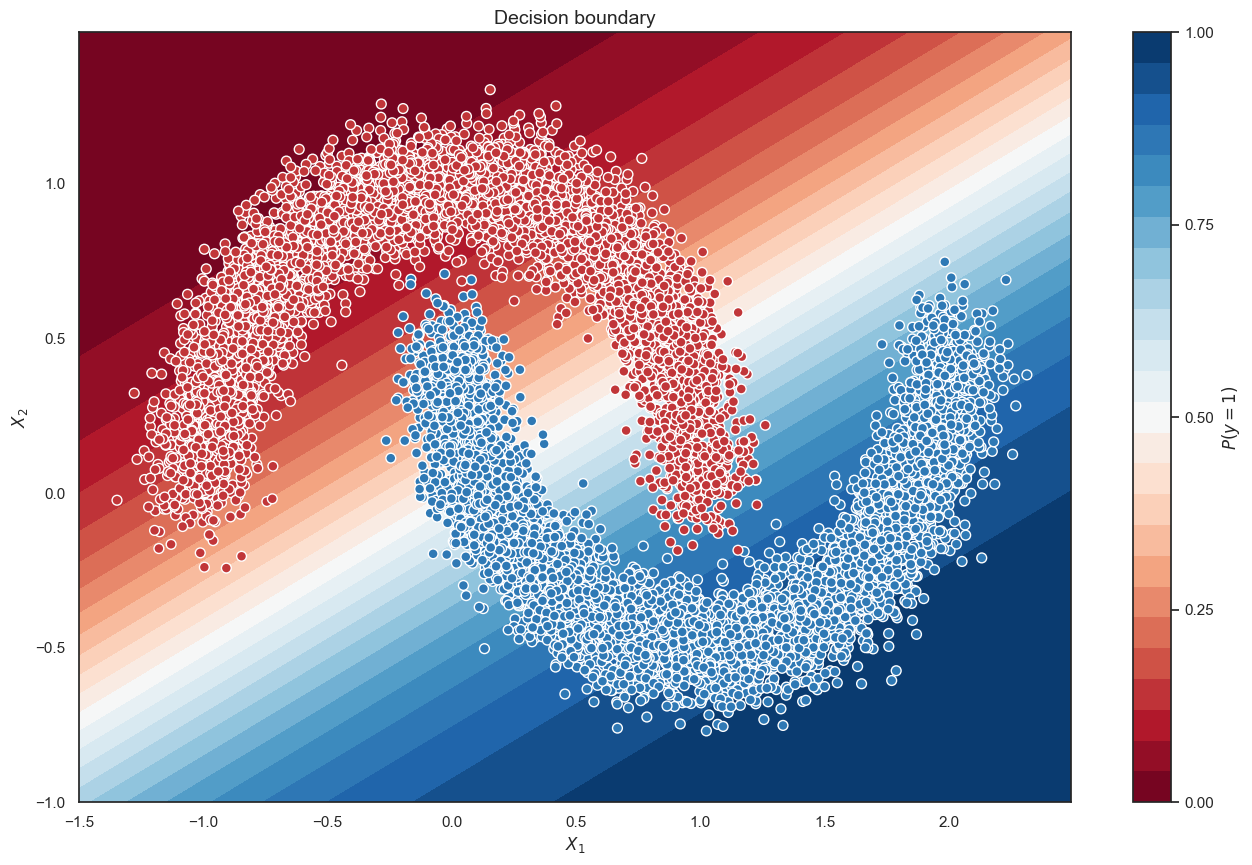

In [15]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [16]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = (torch.sigmoid(model.forward(x_batch)) > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [17]:
from sklearn.metrics import accuracy_score

preds = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t.numpy(), preds)

0.862

**Вопрос 2**

Какое `accuracy` получается после обучения?

**Ответ:**
0.862

# Часть 2. Датасет MNIST

In [19]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

100%|██████████| 9.91M/9.91M [12:22<00:00, 13.3kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 122kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 561kB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


## Часть 2.1. Полносвязные нейронные сети

In [20]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [22]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)



```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [26]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.87975
Loader: valid. Accuracy: 0.9258
Epoch: 2
Loader: train. Accuracy: 0.94305
Loader: valid. Accuracy: 0.9514
Epoch: 3
Loader: train. Accuracy: 0.9591833333333334
Loader: valid. Accuracy: 0.9579
Epoch: 4
Loader: train. Accuracy: 0.9685333333333334
Loader: valid. Accuracy: 0.9651
Epoch: 5
Loader: train. Accuracy: 0.9741
Loader: valid. Accuracy: 0.9681
Epoch: 6
Loader: train. Accuracy: 0.9785666666666667
Loader: valid. Accuracy: 0.9689
Epoch: 7
Loader: train. Accuracy: 0.9813666666666667
Loader: valid. Accuracy: 0.9717
Epoch: 8
Loader: train. Accuracy: 0.9834333333333334
Loader: valid. Accuracy: 0.9721
Epoch: 9
Loader: train. Accuracy: 0.9855833333333334
Loader: valid. Accuracy: 0.9711
Epoch: 10
Loader: train. Accuracy: 0.9865666666666667
Loader: valid. Accuracy: 0.9679


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [27]:
elu_accuracy = accuracy["valid"]

In [28]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    accuracy = {"train": [], "valid": []}
    max_epochs = 10
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch + 1}")
            print(f"Activation: {activation}. Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
            accuracy[k].append(epoch_correct / epoch_all)
    return accuracy["valid"]

In [30]:
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())
tanh_accuracy = test_activation_function(nn.Tanh())
print(plain_accuracy, relu_accuracy, leaky_relu_accuracy, tanh_accuracy)

Epoch: 1
Activation: Identical(). Loader: train. Accuracy: 0.8641666666666666
Activation: Identical(). Loader: valid. Accuracy: 0.885
Epoch: 2
Activation: Identical(). Loader: train. Accuracy: 0.89585
Activation: Identical(). Loader: valid. Accuracy: 0.8992
Epoch: 3
Activation: Identical(). Loader: train. Accuracy: 0.9002166666666667
Activation: Identical(). Loader: valid. Accuracy: 0.9002
Epoch: 4
Activation: Identical(). Loader: train. Accuracy: 0.9026333333333333
Activation: Identical(). Loader: valid. Accuracy: 0.9006
Epoch: 5
Activation: Identical(). Loader: train. Accuracy: 0.90425
Activation: Identical(). Loader: valid. Accuracy: 0.9009
Epoch: 6
Activation: Identical(). Loader: train. Accuracy: 0.9058833333333334
Activation: Identical(). Loader: valid. Accuracy: 0.9008
Epoch: 7
Activation: Identical(). Loader: train. Accuracy: 0.9067333333333333
Activation: Identical(). Loader: valid. Accuracy: 0.901
Epoch: 8
Activation: Identical(). Loader: train. Accuracy: 0.9081833333333333
A

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

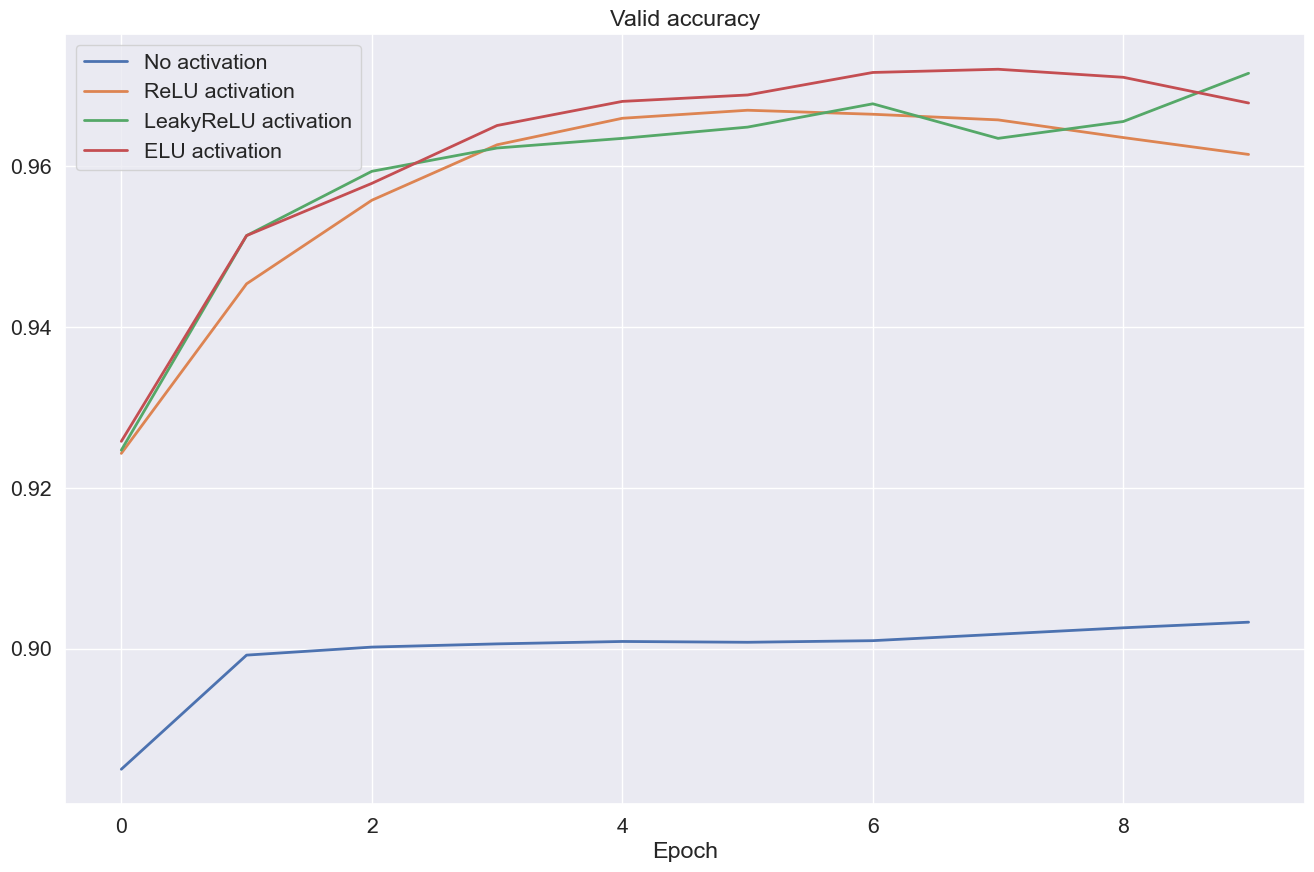

In [31]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

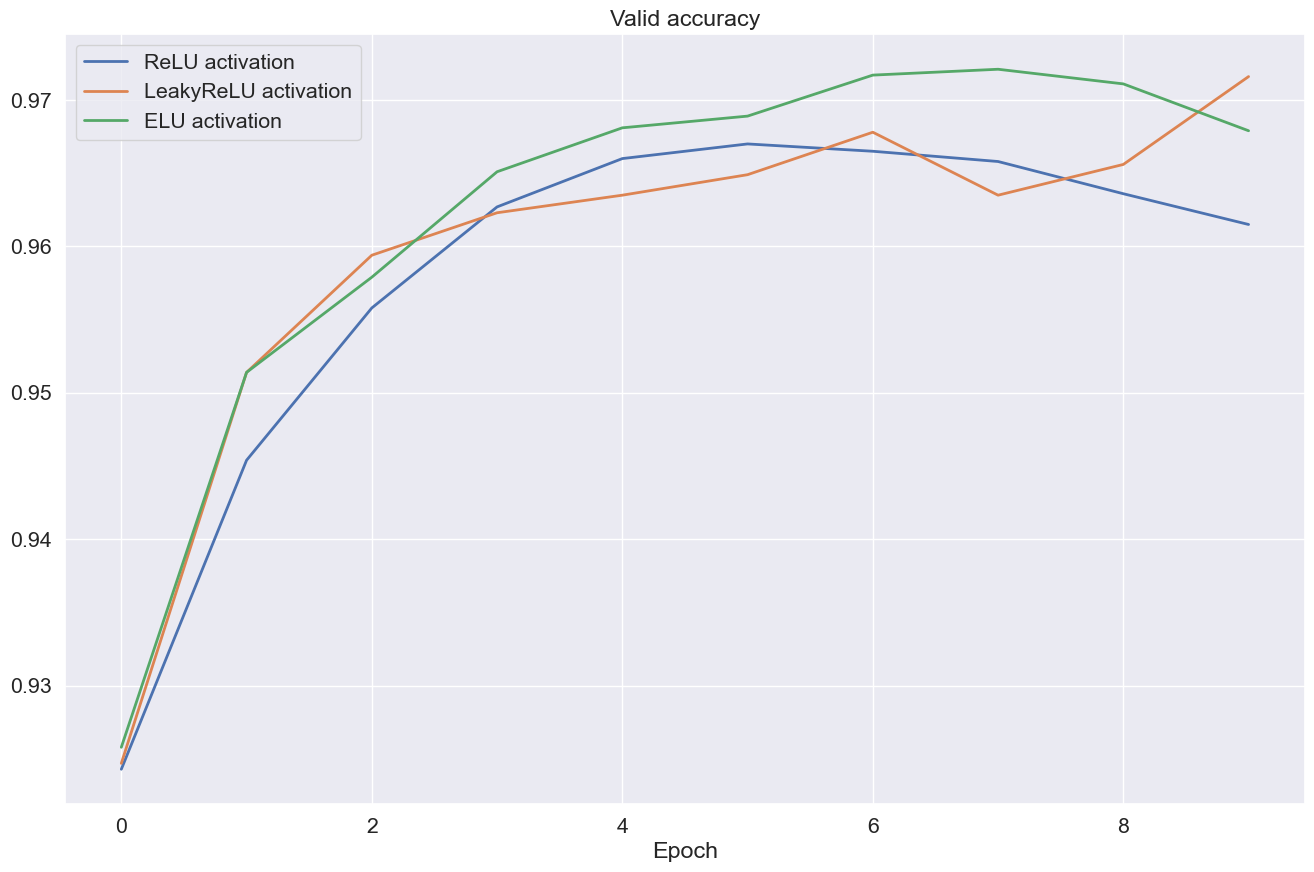

In [32]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 3.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**
LeakyReLU